In [1]:
%qtconsole

In [4]:
import sys
import os
from os.path import join, basename
from pathlib import Path
project_root = os.path.abspath('../')
sys.path.append(os.path.abspath('../models/v3/base/')) #Add the model source to the path
sys.path.append(os.path.abspath('../src/models/dataloaders'))
sys.path.append(os.path.abspath('../src/'))
import matplotlib.pyplot as plt

from PairedImages import normalize
from models import UNet

from pytorch_utils import util

In [2]:
#Load the trianed network
import torch
Net = UNet()

nets = {'Net': Net}.items()
dir = join(project_root,'models','v3','base','saves','run_on_sapelo2.sh_epoch800')

for key,val in nets:
    state_dict = torch.load(dir + '/' + key + '.net') #, map_location=lambda storage, loc: storage)
    val.load_state_dict(state_dict)
    
Net = Net.to('cuda')

In [33]:
from tqdm import tqdm
import torch
from skimage import io
import numpy as np
from data.utils import crop
from skimage.util import pad

data_path = join(project_root, "data/raw/Veins machine learning with Chris/Untraced Veins")
# 1156-1 rough image
image_path = join(data_path,'1118-2.jpeg')
image = io.imread(image_path)
segmentedDR = np.zeros((image.shape[0],image.shape[1]))
segmentedUL = np.zeros((image.shape[0],image.shape[1]))

PADDING = 92
pad_width = (
    (PADDING,PADDING), # x
    (PADDING,PADDING),  # y
    (0,0),   # C channel
)
image = pad(image,pad_width,'reflect')

Net = Net.eval()

step = 388

x_starts = np.append(np.arange(0,image.shape[0]-572,step),image.shape[0]-572 - 1)
y_starts = np.append(np.arange(0,image.shape[1]-572,step),image.shape[1]-572 - 1)

with torch.no_grad():
    for x_start in tqdm(x_starts):
        for y_start in y_starts:
            tile = crop(image,
                        (x_start,y_start),
                        (572,572))

            x = torch.from_numpy(tile).permute(2,0,1).unsqueeze(0).float().to('cuda')
            seg = Net(normalize(x))
            segmentedDR[x_start:x_start+388,y_start:y_start+388] = seg.detach().to('cpu')[0,0]

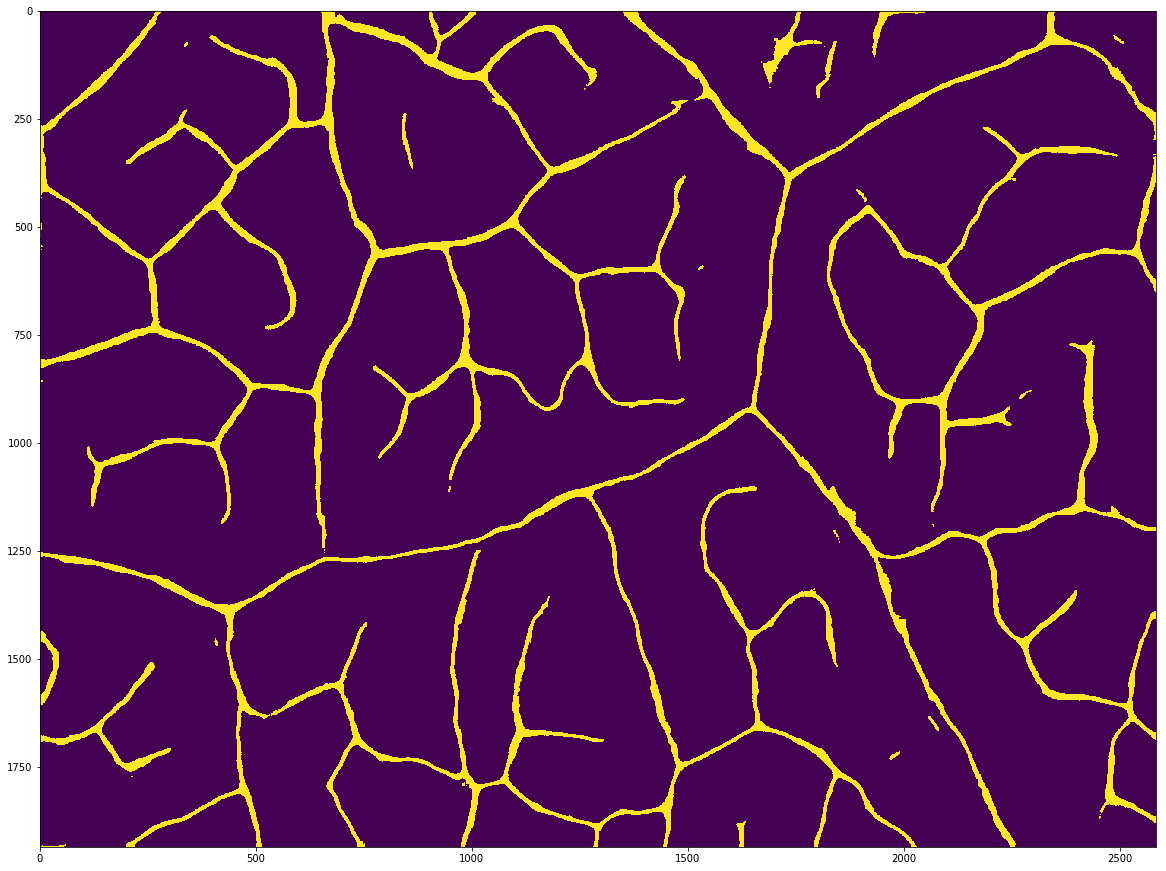

In [25]:
import skimage.morphology as mph

segmented =  segmentedDR

plt.figure(figsize=(20,20))
plt.imshow(segmented > 0.3)
plt.show()

io.imsave('segmented.png',segmented)

In [43]:
from sklearn.metrics import jaccard_similarity_score

def test_average(net, dataset, N=5,threshold = 0.6, device = 'cuda'):
    IoU_loss = []
    with torch.no_grad():
        for i in tqdm(range(N)):
            x, target = dataset.__getitem__(i)
            x = x.to(device=device, non_blocking=True) # p(x,y)
            y = net(x.unsqueeze(0)).to('cpu')
            y = y[0,0].to('cpu')
            IoU_loss.append(jaccard_similarity_score(target,y > threshold))

    return IoU_loss, x[0].to('cpu'), target, y.to('cpu')

In [44]:
from PairedImages import PairedImages

data_path = join(project_root,'data','processed','veins','test')
train_data = PairedImages(data_path,augment=False)

In [45]:
IoU, x, target, y = test_average(Net,train_data, N=len(train_data), threshold = 0.3)

100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


(array([ 6., 13., 25., 16.,  5.,  5.,  2.,  3.,  4.,  1.]),
 array([0.20566603, 0.2671034 , 0.32854077, 0.38997814, 0.45141551,
        0.51285288, 0.57429024, 0.63572761, 0.69716498, 0.75860235,
        0.82003972]),
 <a list of 10 Patch objects>)

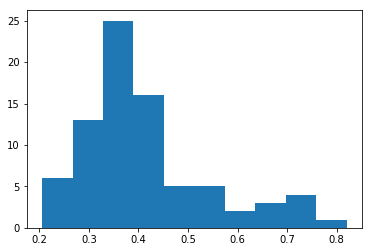

In [46]:
plt.hist(IoU)

0.41386605807028803


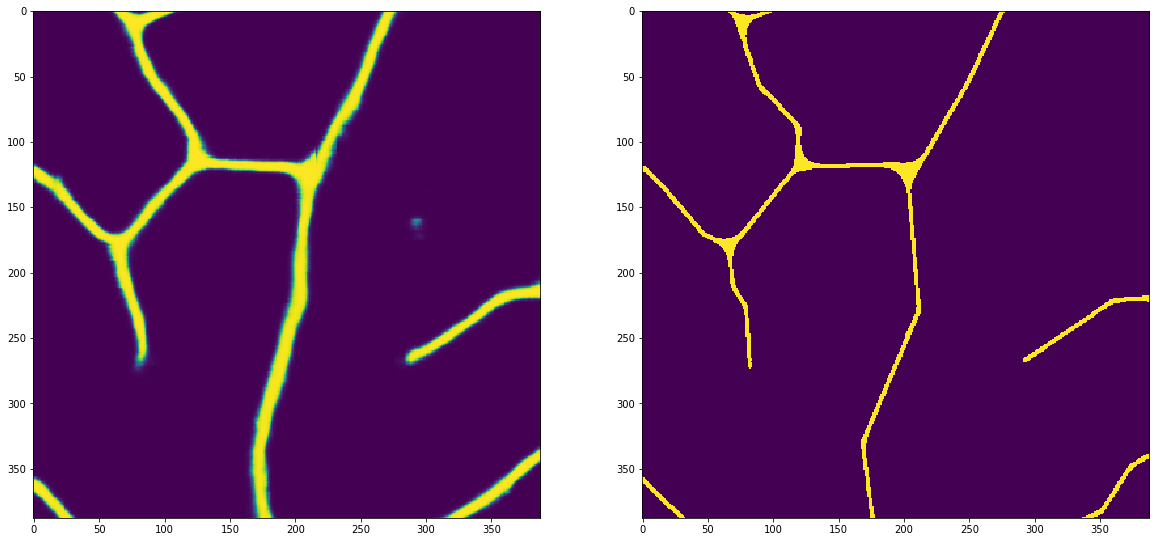

In [47]:
print(sum(IoU)/len(IoU))

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(y)
plt.subplot(122)
plt.imshow(target.numpy())
plt.show()